# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

План:

1. [Загрузка и подготовка данных.](#start)

2. [Исследование задачи, обучение модели без учёта дисбаланса классов.](#exploration)

3. [Борьба с дисбалансом, построение модели с учетом дисбаланса классов.](#disbalance)

4. [Финальное тестирование.](#test)

5. [Измерение AUC-ROC.](#auc-roc)

6. [Выводы.](#conclusion)


# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/datasets/Churn.csv')


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


мы наблюдаем пропуски в таком признаке, как количество недвижимости у клиента,к тому же тип данных у данного признака несоответствующий, в частности должен быть целочисленный. В части наличия пропусков по данному признаку можно предположить, что это связано с отсутствием недвижимости у данных клиентов, поэтому пропуски можно заменить на 0 и изменить тип данных на целочисленный. Также, мы наблюдаем признаки, которые вряд ли помогут нам в решении нашей задачи, в частности 'RowNumber' (индекс строки в данных),'CustomerId' (уникальный идентификатор клиента),'Surname' (фамилия), поэтому, чтобы не нагружать модель лишней информацией, эти признаки мы удалим.

С целью установления возможной мультиколлениарности рассматриваемых факторов, которая может стать причиной переробучения модели и увеличения сложности модели обучения, то есть факторов, которые имеют сильную связь друг с другом, посмотрим значения коэффициентов корреляции по рассматриваемым переменным. Будем считать, что две переменных коллинеарны, когда они находятся между собой в линейной зависимости, то есть если коэффициент корреляции более 0,7. Таким методом сравнивать будем только количественные признаки

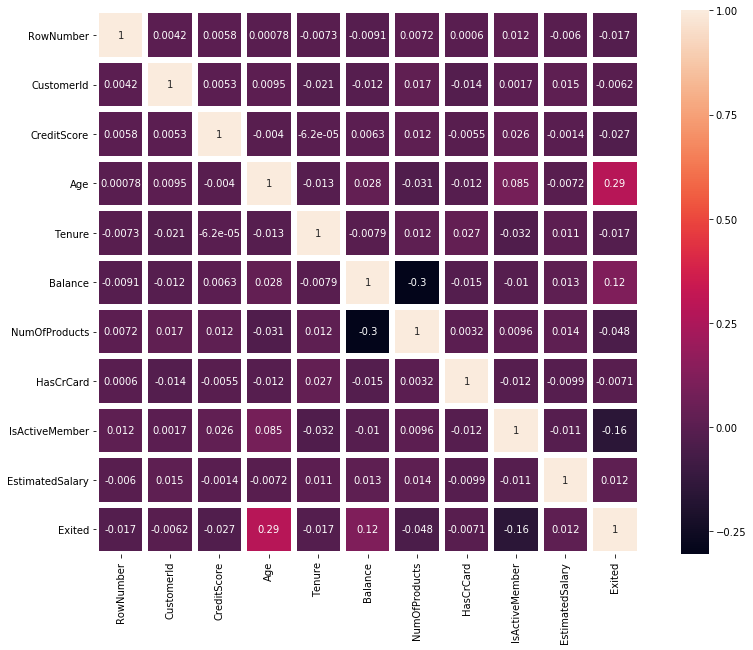

In [5]:
df_corr = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='90')
sns.heatmap(df_corr, square=True, linewidths=5, annot=True);

Больших значений коэффициентов корелляции по рассматриваемым количественным признакам не наблюдаем, соответственно мультиколлениарность по данным факторам также не наблюдаем.

удаляем из датасета "лишние" признаки

In [6]:
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

заполняем нулями пропуски в столбце с информацией о наличии недвижимости

In [7]:
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

### Выводы

В ходе выполнения первого шага мы открыли интересующий файл с данными, сохранив его в датафрейме df, а также получили общую информацию об указанном датафрейме.
Таблица включает в себя 14 признаков и 10 000 объектов.

Признаки

RowNumber — индекс строки в данных (int64)

CustomerId — уникальный идентификатор клиента (int64)

Surname — фамилия (object)

CreditScore — кредитный рейтинг (int64)

Geography — страна проживания (object)

Gender — пол (object)

Age — возраст (int64)

Tenure — количество недвижимости у клиента (float64)

Balance — баланс на счёте (float64)

NumOfProducts — количество продуктов банка, используемых клиентом (int64)

HasCrCard — наличие кредитной карты (int64)

IsActiveMember — активность клиента (int64)

EstimatedSalary — предполагаемая зарплата (float64)

Exited — факт ухода клиента (int64)

Целевым признаком является Exited, остальные признаки будут служить для обучения модели, т.е. модель, которую мы попытаемся построить, будет предсказывать значение 1, если клиент вероятнее всего уйдет из банка, и 0, если останется. В этом и заключается задача бинарной классификации, т.к. наш целевой признак является категориальным.

Также, мы обнаружили такую проблему, как пропуски в признаке со значениями количества недвижимости у клиента,к тому же тип данных у данного признака также несоответствующий, в частности float64, а должен быть целочисленный. В части наличия пропусков по данному признаку мы предположили, что это возможно связано с отсутствием недвижимости у данных клиентов, поэтому мы приняли решение заменить пропуски на 0 и изменить тип данных на целочисленный. Также, мы обнуржили признаки, которые вряд ли помогут нам в решении нашей задачи, в частности 'RowNumber' (индекс строки в данных),'CustomerId' (уникальный идентификатор клиента),'Surname' (фамилия), поэтому, чтобы не нагружать модель лишней информацией, эти признаки мы удалили из датасета.

С целью установления возможной мультиколлениарности рассматриваемых факторов, которая может стать причиной переробучения модели и увеличения сложности модели обучения, то есть факторов, которые имеют сильную связь друг с другом, мы посмотрели значения коэффициентов корреляции по рассматриваемым количественным переменным. Вместе с тем, мультиколлинеарность по количественным признакам не обнаружена.

<a id="exploration"></a>
# 2. Исследование задачи

Рисуем гистограмму значений оттока и оставшихся клиентов


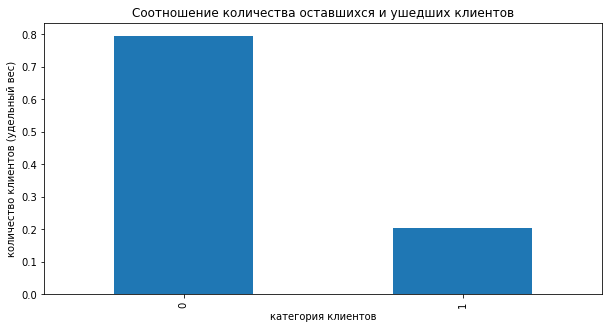

In [8]:
f, ax = plt.subplots(nrows=1, figsize=(10, 5))
df['Exited'].value_counts(normalize=True).plot.bar()
ax.set(title='Соотношение количества оставшихся и ушедших клиентов', xlabel= 'категория клиентов', ylabel = 'количество клиентов (удельный вес)');

Соотношение количества ушедших из банка и оставшихся клиентов 1:4. Такое соотношение говорит о наличии дисбаланса классов.

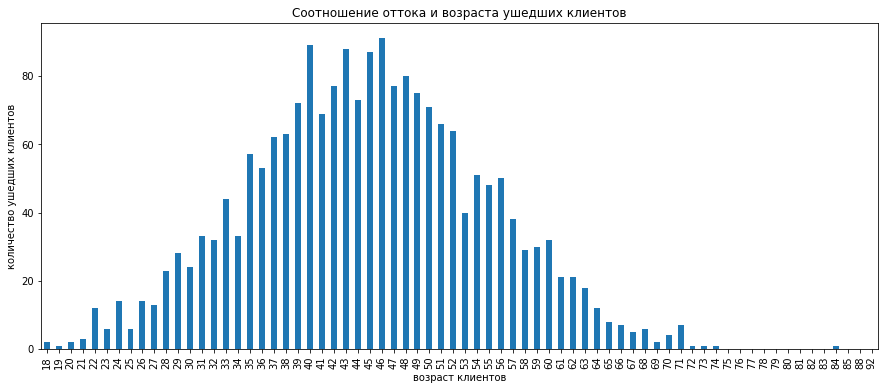

In [9]:
f, ax = plt.subplots(nrows=1, figsize=(15, 6))
df.groupby('Age')['Exited'].sum().plot.bar()
ax.set(title='Соотношение оттока и возраста ушедших клиентов', xlabel= 'возраст клиентов', ylabel = 'количество ушедших клиентов');

По гистограмме мы наблюдаем нормальное распределение. Больше всего уходит клиентов в возрасте от 39 до 50 лет.

Вместе с тем, для того, чтобы делать какие-либо выводы о зависимости признака (возраст) и целевой переменной по графику распределения, необходимо построить распределение признака у альтернативного значения целевого значения, то есть 0.

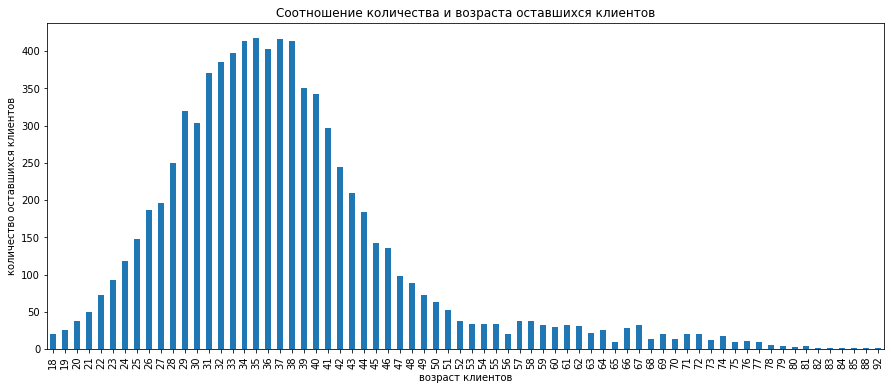

In [10]:
f, ax = plt.subplots(nrows=1, figsize=(15, 6))
df.query('Exited == 0').groupby('Age')['Exited'].count().plot.bar()
ax.set(title='Соотношение количества и возраста оставшихся клиентов', xlabel= 'возраст клиентов', ylabel = 'количество оставшихся клиентов');

здесь мы также наблюдаем нормальное распределение, однако возрастной диапазон клиентов отличается, большинство оставшихся клиентов в возрасте от 28 до 44 лет.

Однако, для закрепления сформированной гипотезы, следует провести статистический тест на равенство средних двух выборок, а именно значения признака (возраст), разделенные по целевому значению 0 и 1.

Проверим гипотезу, что средний возраст двух категорий клиентов одинаковый. Здесь мы выясняем, есть ли разница между совокупностями, поэтому нулевая гипотеза должна быть такая: «нет, разницы нет, то есть исследуемые параметры равны». Исходя из этого ниже следуют нулевая и альтернативная гипотезы, альтернативная, соответсвтенно, прямо противоположная.

H0 - средний возраст клиентов ушедших и оставшихся клиентов не различается.

H1 - средний возраст клиентов ушедших и оставшихся клиентов различается.

In [11]:
df_1 = df.query('Exited == 1')
df_0 = df.query('Exited == 0')
df_1_age = df_1['Age']
df_0_age = df_0['Age']


перед проведением проверки гипотезы через Т-критерий Стьюдента сравним дисперсии двух рассматриваемых выборок, и если они отличаются более, чем на 5%, то считаем отличие значимым и параметр equal_var задаем равным False

In [12]:
variance_df_1 = np.var(df_1_age, ddof=1)
variance_df_0 = np.var(df_0_age, ddof=1)

In [13]:
variance_difference = ((variance_df_1-variance_df_0)/variance_df_0)*100

In [14]:
variance_difference

-7.05684764156979

мы видим, что разница составляет более 7%

In [15]:
from scipy import stats as st
alpha = 0.05 

In [16]:
results = st.ttest_ind(
    df_1_age, 
    df_0_age, equal_var = False)

In [17]:
print('p-значение:', results.pvalue)

p-значение: 4.7127272656641046e-179


In [18]:
if (results.pvalue < alpha):
    print("Средний возраст ушедших и оставшихся клиентов различается, так как значение статистичекой значимости меньше критического уровня статистической  значимости, поэтому мы можем опровергнуть нулевую гипотезу.")
else:
    print("Средний возраст ушедших и оставшихся клиентов не различается, так как значение статистической значимости больше критического уровня статистической  значимости, поэтому мы не можем опровергнуть нулевую гипотезу.")

Средний возраст ушедших и оставшихся клиентов различается, так как значение статистичекой значимости меньше критического уровня статистической  значимости, поэтому мы можем опровергнуть нулевую гипотезу.


таким образом мы можем сделать вывод, что между возрастом клиентов и целевым признаком определенно имеется зависимость

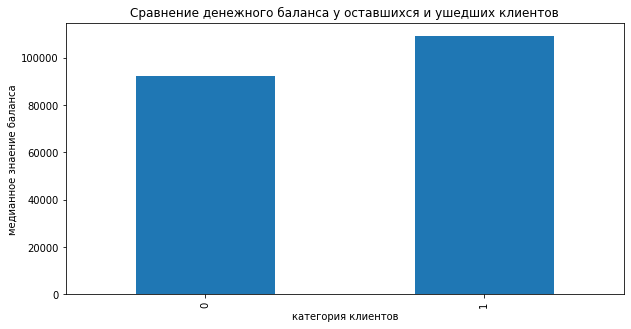

In [19]:
f, ax = plt.subplots(nrows=1, figsize=(10, 5))
df.groupby('Exited')['Balance'].median().plot.bar()
ax.set(title='Сравнение денежного баланса у оставшихся и ушедших клиентов', xlabel= 'категория клиентов', ylabel = 'медианное знаение баланса');

мы можем видеть, что разница не столь существенна, но значение медианы баланса немного выше у тех, кто ушел.

Посмотрим, как зависит наличие недвижимости и отток клиентов 

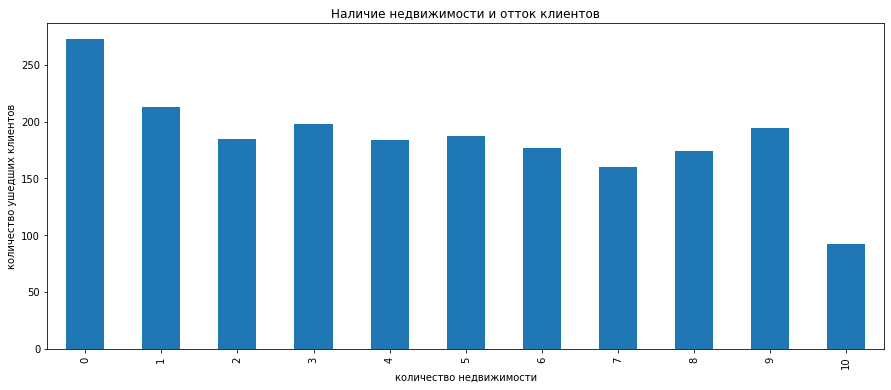

In [20]:
f, ax = plt.subplots(nrows=1, figsize=(15, 6))
df.groupby('Tenure')['Exited'].sum().plot.bar()
ax.set(title='Наличие недвижимости и отток клиентов', xlabel= 'количество недвижимости', ylabel = 'количество ушедших клиентов');

Можем видеть, что те, у кого отсутствует недвижимость, уходят чаще других.

Вместе с тем, для того, чтобы делать какие-либо выводы о зависимости признака (количество недвижимости) и целевой переменной, необходимо построить распределение признака у альтернативного значения целевого значения, то есть 0.

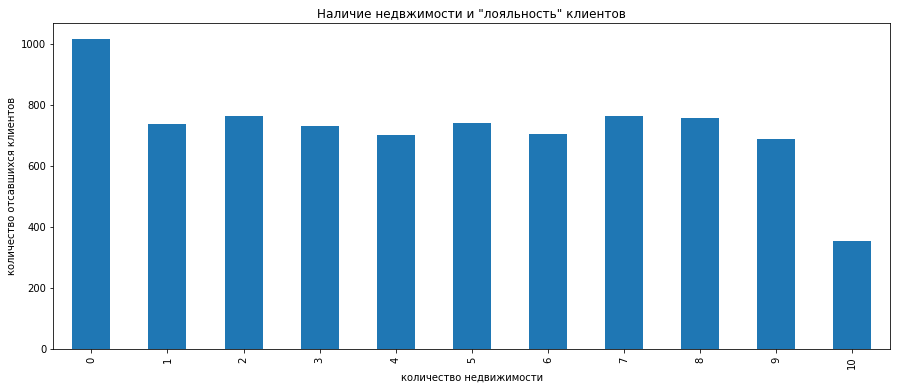

In [21]:
f, ax = plt.subplots(nrows=1, figsize=(15, 6))
df.query('Exited == 0').groupby('Tenure')['Exited'].count().plot.bar()
ax.set(title='Наличие недвжимости и "лояльность" клиентов', xlabel= 'количество недвижимости', ylabel = 'количество отсавшихся клиентов');

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Обрати внимание, что наши действия повторяются, это говорит о том, что мы можем создать функцию для построения графиков. Тем самым оптимизировав свой код.
    
</div>

видим, что существенного отличия между двумя распределениями нет, поэтому мы не можем однозначно утверждать, что количество недвижимости влияет на отток клиентов

#### Избавляемся от категориальных признаков методом One hot encoder

In [22]:
df_ohe = pd.get_dummies(df, drop_first=True)

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Лучше всего явным образом указывать категориальные переменные в методе `get_dummies`, чтобы случайным образом не создать дополнительные не нужные переменные.    
</div>

In [23]:
target=df_ohe['Exited'] # Целевой признак
features=df_ohe.drop(['Exited'],axis=1) # Признаки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

60% отводим под обучающую выборку, а 40 % на валидационную

In [24]:
df_train, df_valid = train_test_split(df_ohe, test_size=0.4, random_state=12345)

Далее, половину из оставшихся 40% отдаем на валидационную, другую половину – на тестовую. Таким образом, соотношение выборок в процентном выражении будет следующим: 60/20/20.

In [25]:
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

посмотрим также на размеры выборок

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

    
В целом выборка разделена верно. Здорово, что показываем итоговое разделение по данным, в том числе можно было подписать их текстом.
    
Я бы рекомендовал бы ещё использовать атрибут `stratify` для целевой переменной. Он дает нам безопасность сохранения 20% значений равного нужного нам количества классов в целевой переменной.
    
</div>

In [26]:
df_train.shape

(6000, 12)

In [27]:
df_valid.shape

(2000, 12)

In [28]:
df_test.shape

(2000, 12)

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

    
Можно также подписать текстом, какое количество каждой выборки у нас получилось. 
    
</div>

как видим, выборки не маленькие, но и недостаточно большие, чтобы не опасаться переобучения модели.

Подготовим фичи и целевые признаки обучающей,валидационной и тестовой выборок

In [29]:
features_train = df_train.drop('Exited', axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop('Exited', axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

Стандартизируем выборки, т.к существует большая разница в значениях, например возраст и баланс. 

In [30]:
numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember', 'EstimatedSalary']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

### Построение моделей без учета дисбаланса классов

### Дерево решений

С помощью цикла найдем лучшее значение гиперпораметра max_depth


In [31]:
best_depth = 0
best_result = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"depth = {depth}:\t{result}")
    if result > best_result:
        best_depth = depth
        best_result = result
print('Лучшая глубина дерева:', best_depth,'Лучшее значение f1:', best_result)

depth = 1:	0.0
depth = 2:	0.5217391304347825
depth = 3:	0.4234875444839857
depth = 4:	0.5528700906344411
depth = 5:	0.5406249999999999
depth = 6:	0.5696969696969697
depth = 7:	0.5320813771517998
depth = 8:	0.5449010654490106
depth = 9:	0.5786516853932585
depth = 10:	0.528995756718529
depth = 11:	0.5201072386058981
depth = 12:	0.5013054830287207
depth = 13:	0.5259067357512954
depth = 14:	0.48391248391248387
depth = 15:	0.5025125628140703
depth = 16:	0.491183879093199
depth = 17:	0.47160493827160493
depth = 18:	0.49014778325123154
depth = 19:	0.4921212121212121
depth = 20:	0.5024154589371981
Лучшая глубина дерева: 9 Лучшее значение f1: 0.5786516853932585


Как видим, лучшее значение max_depth=9, при котором F1=0,578

### Случайный лес

Снова с помощью цикла найдем лучший гиперпораметр max_depth уже для случайного леса


In [32]:
best_depth = 0
best_result = 0
for depth in range(1, 21):
    model = RandomForestClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"max_depth = {depth}:\t{result}")    
    if result > best_result:
        best_depth = depth
        best_result = result
print('Лучший показатель depth:', best_depth,'Лучшее значение F1:', best_result)

max_depth = 1:	0.0
max_depth = 2:	0.2
max_depth = 3:	0.25102880658436216
max_depth = 4:	0.476843910806175
max_depth = 5:	0.4727891156462586
max_depth = 6:	0.5463258785942492
max_depth = 7:	0.5408805031446541
max_depth = 8:	0.5527156549520766
max_depth = 9:	0.5800604229607251
max_depth = 10:	0.5735963581183612
max_depth = 11:	0.5692541856925418
max_depth = 12:	0.5884057971014492
max_depth = 13:	0.5863095238095238
max_depth = 14:	0.5677233429394813
max_depth = 15:	0.5836909871244635
max_depth = 16:	0.5788712011577425
max_depth = 17:	0.576923076923077
max_depth = 18:	0.5595238095238096
max_depth = 19:	0.5777777777777778
max_depth = 20:	0.5438066465256799
Лучший показатель depth: 12 Лучшее значение F1: 0.5884057971014492


In [33]:
best_estim = 0
best_result = 0
for estim in range(1, 101,2):
    model = RandomForestClassifier(n_estimators=estim, max_depth=12, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"n_estimators = {estim}:\t{result}")    
    if result > best_result:
        best_estim = estim
        best_result = result
print('Лучший показатель количества деревьев:', best_estim,'Лучшее значение F1:', best_result)

n_estimators = 1:	0.5269761606022584
n_estimators = 3:	0.5786516853932585
n_estimators = 5:	0.5726495726495726
n_estimators = 7:	0.5841726618705035
n_estimators = 9:	0.5959302325581396
n_estimators = 11:	0.5875542691751084
n_estimators = 13:	0.5935672514619883
n_estimators = 15:	0.5946745562130178
n_estimators = 17:	0.5925925925925927
n_estimators = 19:	0.5943536404160475
n_estimators = 21:	0.5937031484257871
n_estimators = 23:	0.5915915915915916
n_estimators = 25:	0.5894736842105264
n_estimators = 27:	0.5834586466165413
n_estimators = 29:	0.5770392749244713
n_estimators = 31:	0.5722983257229833
n_estimators = 33:	0.5744680851063829
n_estimators = 35:	0.5800604229607251
n_estimators = 37:	0.5907046476761619
n_estimators = 39:	0.5912518853695324
n_estimators = 41:	0.5891238670694864
n_estimators = 43:	0.5975975975975975
n_estimators = 45:	0.5891238670694864
n_estimators = 47:	0.5954887218045113
n_estimators = 49:	0.5903614457831324
n_estimators = 51:	0.5805471124620061
n_estimators = 53

таким образом, в лучше модели случайного леса количество деревьев равно 43, а глубина дерева равна 12, F1 при этом равен 0,597, то есть лучше, чем у дерева решений

In [61]:
for i in range(10):
    for j in range(20):
        print(i, j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19


### Логистическая регрессия

выберем оптимальное значение max_iter

In [34]:
best_max_iter = 0
best_result = 0

for max_iter in range(1,101):
    model = LogisticRegression(random_state=12345, max_iter=max_iter)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    result = f1_score(target_valid,valid_predictions)
    print('Количество итерраций:', max_iter,'F1:',result)
    if result > best_result:
        best_max_iter = max_iter
        best_result = result

print('Лучший показатель количества итерраций:', best_max_iter,'Лучшее значение F1:', best_result)

Количество итерраций: 1 F1: 0.23166023166023164
Количество итерраций: 2 F1: 0.3264604810996563
Количество итерраций: 3 F1: 0.3316412859560068
Количество итерраций: 4 F1: 0.33389544688026984
Количество итерраций: 5 F1: 0.33389544688026984
Количество итерраций: 6 F1: 0.33389544688026984
Количество итерраций: 7 F1: 0.33389544688026984
Количество итерраций: 8 F1: 0.33389544688026984
Количество итерраций: 9 F1: 0.33389544688026984
Количество итерраций: 10 F1: 0.33389544688026984
Количество итерраций: 11 F1: 0.33389544688026984
Количество итерраций: 12 F1: 0.33389544688026984
Количество итерраций: 13 F1: 0.33389544688026984
Количество итерраций: 14 F1: 0.33389544688026984
Количество итерраций: 15 F1: 0.33389544688026984
Количество итерраций: 16 F1: 0.33389544688026984
Количество итерраций: 17 F1: 0.33389544688026984
Количество итерраций: 18 F1: 0.33389544688026984
Количество итерраций: 19 F1: 0.33389544688026984
Количество итерраций: 20 F1: 0.33389544688026984
Количество итерраций: 21 F1: 0.

значение F1 в логистической регрессии получилось значительно хуже, чем у деревьев

### Вывод

В ходе выполнения 2 шага мы исследовали баланс классов. Мы обнаружили, что соотношение количества ушедших из банка и оставшихся клиентов 1:4. Такое соотношение может говорить о наличии дисбаланса классов. 

Также посмотрели на зависимость целевого признака от других рассматриваемых признаков. Так, к примеру, мы обнаружили, что существует зависимость между целевым признаком и возрастом клиентов.

кроме того, методом One hot Encoder мы избавились от категориальных признаков, а также стандартизировали рассматриваемые данные ввиду наличия большой разницы в значениях.

Также, мы обучили модель без учёта дисбаланса, используя дерево решений, случайный лес и логистическую регрессию.

Самый лучший результата показала модель случайного леса, при лучшем значении max_depth=12 и количестве деревьев -43, мы получили значение F1-меры =0,597, хуже всего себя показала логистическая регрессия, тут F1 = 0.33.

<a id="disbalance"></a>
# 3. Борьба с дисбалансом

Используем технику Upsampling и увеличим количество ушедших клиентов(target==1)¶

In [35]:
def upsampling (features,target,repeat):
    #Разделим выборку по значениям целевой функции
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    #Увеличиваем путем дублирования и соединяем обратно
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    # Перемешиваем
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=1234)
    
    return upsampling_features,upsampling_target

In [36]:
features_balance_up,target_balance_up=upsampling(features_train,target_train,4)

Используем технику Downsampling и уменьшим количество оставшихся клиентов(target==0)¶

In [37]:
def downsampling(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=1234)
    return downsampling_features,downsampling_target

In [38]:
features_balance_down,target_balance_down=downsampling(features,target,0.4)

Ввиду того, что количество данных не такое большое, принято решение, не использовать метод уменьшения выборки, к тому же результаты после его использования получались хуже, чем при использовании Upsamling, поэтому используем последний.


#### Обучим разные модели с учетом дисбаланса и найдем лучшую

Произведем те же вычисления, что производили без учета дисбаланса, используя дерево решений, случаный лес и логистическую регрессию

#### Дерево решений

In [39]:
best_depth = 0
best_result = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(features_balance_up,target_balance_up)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"depth = {depth}:\t{result}")
    if result > best_result:
        best_depth = depth
        best_result = result
print('Лучшая глубина дерева:', best_depth,'Лучшее значение f1:', best_result)

depth = 1:	0.4994903160040775
depth = 2:	0.541015625
depth = 3:	0.541015625
depth = 4:	0.5277777777777778
depth = 5:	0.5963791267305644
depth = 6:	0.5581835383159887
depth = 7:	0.5559999999999999
depth = 8:	0.538160469667319
depth = 9:	0.5284872298624754
depth = 10:	0.5149469623915139
depth = 11:	0.5270684371807968
depth = 12:	0.5015544041450777
depth = 13:	0.5026852846401718
depth = 14:	0.4910313901345292
depth = 15:	0.4826789838337182
depth = 16:	0.4777911164465786
depth = 17:	0.4690157958687728
depth = 18:	0.4730392156862745
depth = 19:	0.4645962732919255
depth = 20:	0.4746600741656366
Лучшая глубина дерева: 5 Лучшее значение f1: 0.5963791267305644


#### Случайный лес

In [40]:
best_depth = 0
best_result = 0
for depth in range(1, 21):
    model = RandomForestClassifier(max_depth=depth, class_weight='balanced',random_state=12345)
    model.fit(features_balance_up,target_balance_up)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"max_depth = {depth}:\t{result}")    
    if result > best_result:
        best_depth = depth
        best_result = result
print('Лучший показатель depth:', best_depth,'Лучшее значение F1:', best_result)

max_depth = 1:	0.5115346038114343
max_depth = 2:	0.5776458951533134
max_depth = 3:	0.567741935483871
max_depth = 4:	0.5938144329896906
max_depth = 5:	0.6086956521739131
max_depth = 6:	0.5949748743718594
max_depth = 7:	0.6166328600405679
max_depth = 8:	0.6069246435845215
max_depth = 9:	0.6097814776274714
max_depth = 10:	0.6213592233009708
max_depth = 11:	0.6043956043956044
max_depth = 12:	0.5898305084745763
max_depth = 13:	0.6025492468134415
max_depth = 14:	0.5703611457036115
max_depth = 15:	0.5834363411619283
max_depth = 16:	0.575796178343949
max_depth = 17:	0.5774834437086092
max_depth = 18:	0.5699481865284973
max_depth = 19:	0.5785997357992073
max_depth = 20:	0.5634178905206944
Лучший показатель depth: 10 Лучшее значение F1: 0.6213592233009708


In [41]:
best_estim = 0
best_result = 0
for estim in range(1, 101,2):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, class_weight='balanced',criterion='entropy', random_state=12345)
    model.fit(features_balance_up,target_balance_up)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    print(f"n_estimators = {estim}:\t{result}")    
    if result > best_result:
        best_estim = estim
        best_result = result
print('Лучший показатель количества деревьев:', best_estim,'Лучшее значение F1:', best_result)

n_estimators = 1:	0.5510009532888465
n_estimators = 3:	0.5829145728643216
n_estimators = 5:	0.6052910052910053
n_estimators = 7:	0.591728525980912
n_estimators = 9:	0.6090621707060063
n_estimators = 11:	0.5974304068522484
n_estimators = 13:	0.5995717344753747
n_estimators = 15:	0.6000000000000001
n_estimators = 17:	0.6092572658772876
n_estimators = 19:	0.6139037433155079
n_estimators = 21:	0.6086021505376343
n_estimators = 23:	0.6127292340884573
n_estimators = 25:	0.6192017259978425
n_estimators = 27:	0.6162162162162163
n_estimators = 29:	0.625136612021858
n_estimators = 31:	0.6215921483097054
n_estimators = 33:	0.6210640608034745
n_estimators = 35:	0.6125541125541126
n_estimators = 37:	0.6183783783783783
n_estimators = 39:	0.623773173391494
n_estimators = 41:	0.6195652173913043
n_estimators = 43:	0.6254071661237784
n_estimators = 45:	0.6203904555314533
n_estimators = 47:	0.6240520043336945
n_estimators = 49:	0.6241900647948164
n_estimators = 51:	0.6285097192224621
n_estimators = 53:	0

#### Логистическая регрессия

In [42]:
best_max_iter = 0
best_result = 0

for max_iter in range(1,11):
    model = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=max_iter)
    model.fit(features_balance_up,target_balance_up)
    valid_predictions = model.predict(features_valid)
    result = f1_score(target_valid,valid_predictions)
    print('Количество итерраций:', max_iter,'F1:',result)
    if result > best_result:
        best_max_iter = max_iter
        best_result = result

print('Лучший показатель количества итерраций:', best_max_iter,'Лучшее значение F1:', best_result)

Количество итерраций: 1 F1: 0.48948696383515566
Количество итерраций: 2 F1: 0.493595217762596
Количество итерраций: 3 F1: 0.488013698630137
Количество итерраций: 4 F1: 0.4888888888888888
Количество итерраций: 5 F1: 0.4888888888888888
Количество итерраций: 6 F1: 0.4888888888888888
Количество итерраций: 7 F1: 0.4888888888888888
Количество итерраций: 8 F1: 0.4888888888888888
Количество итерраций: 9 F1: 0.4888888888888888
Количество итерраций: 10 F1: 0.4888888888888888
Лучший показатель количества итерраций: 2 Лучшее значение F1: 0.493595217762596


In [43]:
best_solver = ''
best_result = 0
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solve in solvers:
    model = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=2, solver=solve)
    model.fit(features_balance_up,target_balance_up)
    valid_predictions = model.predict(features_valid)
    result = f1_score(target_valid,valid_predictions)
    print('Solver:', solve,'Точность:',result)
    if result > best_result:
        best_solver= solve
        best_result = result
print('Лучшее значение solver:', best_solver,'Лучшая точность:', best_result)

Solver: newton-cg Точность: 0.49238578680203043
Solver: lbfgs Точность: 0.4913194444444445
Solver: liblinear Точность: 0.493595217762596
Solver: sag Точность: 0.46559999999999996
Solver: saga Точность: 0.48583690987124467
Лучшее значение solver: liblinear Лучшая точность: 0.493595217762596


#### Отобразим модели с лучшими результатами

In [44]:
%%time
best_tree_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=12345)
best_tree_model.fit(features_balance_up,target_balance_up)
predictions_valid = best_tree_model.predict(features_valid)
result = f1_score(target_valid,predictions_valid)
print('Лучшая модель дерева решений','F1:',result)

Лучшая модель дерева решений F1: 0.5963791267305644
CPU times: user 33.3 ms, sys: 72 µs, total: 33.4 ms
Wall time: 31.6 ms


In [45]:
%%time
best_logistic_model = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=2)
best_logistic_model.fit(features_balance_up,target_balance_up)
valid_predictions = best_logistic_model.predict(features_valid)
result = f1_score(target_valid,valid_predictions)
print('Лучшая логистическая модель','F1:',result)

Лучшая логистическая модель F1: 0.493595217762596
CPU times: user 54.4 ms, sys: 47.9 ms, total: 102 ms
Wall time: 69 ms


In [46]:
%%time
best_forest_model = RandomForestClassifier(n_estimators=73, max_depth=10, class_weight='balanced',criterion='entropy', random_state=12345)
best_forest_model.fit(features_balance_up,target_balance_up)
predictions_valid = best_forest_model.predict(features_valid)
result = f1_score(target_valid,predictions_valid)
print('Лучшая модель случайного леса','F1',result)

Лучшая модель случайного леса F1 0.6308871851040525
CPU times: user 894 ms, sys: 4.07 ms, total: 898 ms
Wall time: 912 ms


Как видим, лучший результат показала модель случайного леса, F1=0.630 при количестве деревьев =73, глубине дерева = 10 и criterion - 'entropy', при этом скорость выполнения кода в данной модели оставляет желать лучшего.

### Вывод

В ходе выполнения третьего шага мы улучшили качество модели, учитывая дисбаланс классов, в частности использовали методы увеличения и уменьшения выборки, но остановились на первом ввиду небольшого количества данных, чтобы уменьшать выборку, и ввиду того, что метод upsampling показал лучшие результаты. С учетом дисбаланса мы обучили разные модели (дерево решений, случайный лес, логистическая регрессия) и нашли лучшую, ей оказалась модель случайного леса, а именно F1=0.630 при количестве деревьев =73, глубине дерева = 10 и criterion - 'entropy', при этом скорость выполнения кода ниже, чем у других рассматриваемых моделей. Лучший показатель F1 у дерева решений равен 0,596, а у логистической регрессии 0,493.

<a id="test"></a>
# 4. Тестирование модели

Проведем финальное тестирование полученных моделей на тестовой выборке.

In [47]:
%%time
model = RandomForestClassifier(n_estimators=73, max_depth=10, class_weight='balanced',criterion='entropy', random_state=12345)
model.fit(features_balance_up,target_balance_up)
predictions_test = model.predict(features_test)
result = f1_score(target_test,predictions_test)
print('F1 на тестовой выборке', result)

F1 на тестовой выборке 0.6116402116402117
CPU times: user 868 ms, sys: 0 ns, total: 868 ms
Wall time: 882 ms


In [48]:
%%time
best_tree_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=12345)
best_tree_model.fit(features_balance_up,target_balance_up)
predictions_test = best_tree_model.predict(features_test)
result = f1_score(target_test,predictions_test)
print('F1 дерева решений на тестовой выборке','F1:',result)

F1 дерева решений на тестовой выборке F1: 0.5809128630705395
CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 29.4 ms


In [49]:
%%time
best_logistic_model = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=2)
best_logistic_model.fit(features_balance_up,target_balance_up)
test_predictions = best_logistic_model.predict(features_test)
result = f1_score(target_test,test_predictions)
print('F1 модели логистической регресси на тестовой выборке','F1:',result)

F1 модели логистической регресси на тестовой выборке F1: 0.480553154710458
CPU times: user 16.2 ms, sys: 11.2 ms, total: 27.3 ms
Wall time: 44.7 ms


### Вывод

В ходе выполнения 4 шага мы тестировали наши лучшие модели на тестовой выборке.
На тестовой выборке лучшая модель случайного леса показывает значение F1, приближенное к тренировочной выборке, но все же  ниже, в частности 0,611. Меньшие значения F1 на тестовых выборках мы наблюдаем и по моделям логистической регрессии, а также дерева решений. Таким образом, в данном случае мы наблюдаем проблему переообучения, но значения отличаются не существенно, поэтому можем считать, что нам удалось построить модель для задачи бинарной классификации, которая предскажет уход клиента.

Таким образом, с учетом того, что выборка не будет большой, в данном случае можно рекомендовать к использованию модель случайного леса.

<a id="auc-roc"></a>
# 5. Измерение AUC-ROC

рисуем roc-кривую и считаем площадь под ней для лучшей модели, а именно случайного леса

In [50]:
probabilities_valid_forest = best_forest_model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [51]:
fpr_forest,tpr_forest,thresholds=roc_curve(target_valid,probabilities_one_valid_forest)

In [52]:
auc_roc_forest=roc_auc_score(target_valid,probabilities_one_valid_forest)

In [53]:
auc_roc_forest

0.8526621259504352

аналогичные расчеты производим для лучшей модели решающего дерева

In [54]:
probabilities_valid_tree = best_tree_model.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

In [55]:
fpr_tree,tpr_tree,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)

In [56]:
auc_roc_tree=roc_auc_score(target_valid,probabilities_one_valid_tree)
auc_roc_tree

0.8310244134068074

аналогичные расчеты производим для модели логистической регрессии

In [57]:
probabilities_valid_logistic = best_logistic_model.predict_proba(features_valid)
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]

In [58]:
fpr_logistic,tpr_logistic,thresholds=roc_curve(target_valid,probabilities_one_valid_logistic)

In [59]:
auc_roc_logistic=roc_auc_score(target_valid,probabilities_one_valid_logistic)
auc_roc_logistic

0.7631926759779579

отображаем roc-кривые на графике, чтобы наглядно видеть, как сильно модель отличается от слчайной.

<Figure size 432x288 with 0 Axes>

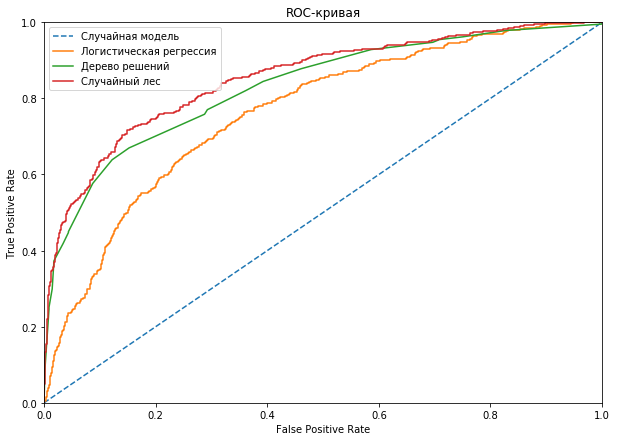

In [60]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_logistic,tpr_logistic)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Логистическая регрессия','Дерево решений','Случайный лес'),
           loc= 'upper left')
plt.show()

### Вывод

В ходе выполнения 5 шага мы измеряли для наших моделей такую метрику, как auc-roc, в частности нарисовали roc-кривые для 3 рассматриваемх моделей и рассчитали площадь под ней.
Мы увидели, что и по данной метрике лучшей оказалась модель случайного леса с показателем auc-roc = 0.852, далее следует решающее дерево со значением roc-auc = 0.831 и в конце рейтинга моделей логистическая регрессия с показателем roc-auc равным 0,763, то есть в данном случае "рейтинг" качества моделей не отличается от такого же "рейтинга", где используется F1-мера, лучшей по обеим метрикам является модель случайного леса, а худшей - логистическа регрессия.



<a id="conclusion"></a>
# 6. Общий вывод

В ходе выполнения данной работы сделано нижеследующее.

* В ходе выполнения первого шага мы открыли интересующий файл с данными, сохранив его в датафрейме df, а также получили общую информацию об указанном датафрейме. Таблица включает в себя 14 признаков и 10 000 объектов.

Целевым признаком является Exited, остальные признаки служили для обучения модели, т.е. модель, которую мы попытались построить, должна была предсказывать значение 1, если клиент вероятнее всего уйдет из банка, и 0, если останется. В этом и заключается задача бинарной классификации, т.к. наш целевой признак является категориальным.

Также, мы обнаружили такую проблему, как пропуски в признаке со значениями количества недвижимости у клиента,к тому же тип данных у данного признака также несоответствующий, в частности float64, а должен быть целочисленный. В части наличия пропусков по данному признаку мы предположили, что это возможно связано с отсутствием недвижимости у данных клиентов, поэтому мы приняли решение заменить пропуски на 0 и изменить тип данных на целочисленный. Также, мы обнуржили признаки, которые вряд ли помогут нам в решении нашей задачи, в частности 'RowNumber' (индекс строки в данных),'CustomerId' (уникальный идентификатор клиента),'Surname' (фамилия), поэтому, чтобы не нагружать модель лишней информацией, эти признаки мы удалили из датасета.

С целью установления возможной мультиколлениарности рассматриваемых факторов, которая может стать причиной переробучения модели и увеличения сложности модели обучения, то есть факторов, которые имеют сильную связь друг с другом, мы посмотрели значения коэффициентов корреляции по рассматриваемым количественным переменным. Вместе с тем, мультиколлинеарность по количественным признакам не обнаружена.

* В ходе выполнения 2 шага мы исследовали баланс классов. Мы обнаружили, что соотношение количества ушедших из банка и оставшихся клиентов 1:4. Такое соотношение может говорить о наличии дисбаланса классов. 

Также посмотрели на зависимость целевого признака от других рассматриваемых признаков. Так, к примеру, мы обнаружили, что существует зависимость между целевым признаком и возрастом клиентов.

кроме того, методом One hot Encoder мы избавились от категориальных признаков, а также стандартизировали рассматриваемые данные ввиду наличия большой разницы в значениях.

Также, мы обучили модель без учёта дисбаланса, используя дерево решений, случайный лес и логистическую регрессию.

Самый лучший результата показала модель случайного леса при лучшем значении max_depth=12 и количестве деревьев -43, мы получили значение F1-меры =0,597, хуже всего себя показала логистическая регрессия, тут F1 = 0.33.


* В ходе выполнения третьего шага мы улучшили качество модели, учитывая дисбаланс классов, в частности использовали методы увеличения и уменьшения выборки, но остановились на первом ввиду небольшого количества данных, чтобы уменьшать выборку, и ввиду того, что метод upsampling показал лучшие результаты. С учетом дисбаланса мы обучили разные модели (дерево решений, случайный лес, логистическая регрессия) и нашли лучшую, ей оказалась модель случайного леса, а именно F1=0.630 при количестве деревьев =73, глубине дерева = 10 и criterion - 'entropy', при этом скорость выполнения кода ниже, чем у других рассматриваемых моделей. Лучший показатель F1 у дерева решений равен 0,596, а у логистической регрессии 0,493.

* В ходе выполнения 4 шага мы тестировали наши лучшие модели на тестовой выборке.
На тестовой выборке лучшая модель случайного леса показала значение F1, приближенное к тренировочной выборке, но все же  ниже, в частности 0,611. Меньшие значения F1 на тестовых выборках мы наблюдали и по моделям логистической регрессии, а также дерева решений. Таким образом, в данном случае мы обнаружили проблему переообучения, но значения отличаются не существенно, поэтому можем считать, что нам удалось построить модель для задачи бинарной классификации, которая предскажет уход клиента.

**Таким образом, с учетом того, что выборка не будет большой, в данном случае можно рекомендовать к использованию модель случайного леса.**


* В ходе выполнения 5 шага мы измеряли для наших моделей такую метрику, как auc-roc, в частности нарисовали roc-кривые для 3 рассматриваемх моделей и рассчитали площадь под ней.
Мы увидели, что и по данной метрике лучшей оказалась модель случайного леса с показателем auc-roc = 0.852, далее следует решающее дерево со значением roc-auc = 0.831 и в конце рейтинга моделей логистическая регрессия с показателем roc-auc равным 0,763, то есть в данном случае "рейтинг" качества моделей не отличается от такого же "рейтинга", где используется F1-мера, лучшей по обеим метрикам является модель случайного леса, а худшей - логистическа регрессия.

